# Photophysics of the Nitrogen-Vacancy (NV) Center in Diamond 

The nitrogen vacancy center (NV center) is the most well studied point defect in diamond, consisting of a substituational nitrogen atom and adjacent vacancy along the 111-crystal axis of the diamond lattice. Its ability to locally detect and measure a number of physical quantities, such as magnetic and electric fields, makes it a promising candidate for quantum sensing, computing and communication applications.
The electronic ground state of the negatively charged NV center is a spin triplet (S= 1) whose spin state can be optically prepared and read-out using green light illumination. This optical addressability enables detection of single NV centers with high sensitivity by means of optically detected magnetic resonance.
In this example notebook we will explore the photophysics of the NV center and theoretically assess optical spin-polarization and spin-dependent fluorescence. Starting from a pseudo-classical rate model we will gradually evolve to a fully quantum mechanical model that accounts for effects of magnetic and electric fields as well as temperature.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import simos as sos

## A simple, (pseudo)-classical rate model

We begin with a simple, pseudo-classical rate model of the negatively charged NV center, encompassing a triplet ground state, a triplet excited state as well as a metastable singlet state. The excited state lies 1.945 eV (637 nm) above the ground state. Here, we consider off-resonant excitation of the NV center from the ground to the excited state, which is commonly achieved with green (~532 nm) laser light. 
The excited state has an optical lifetime of about 16 ns and decays either radiatively by emission of a red photon, or nonradiatively via an intersystem crossing (ISC) to the metastable singlet state.  This ISC is strongly spin dependent, resulting in (i) higher fluorescence intensity for the $m_S = 0$ spin state versus the $m_S = 1$ spin state and (ii) polarization of the spin state to $m_S = 0$ throughout multiple excitation-decay cycles.  


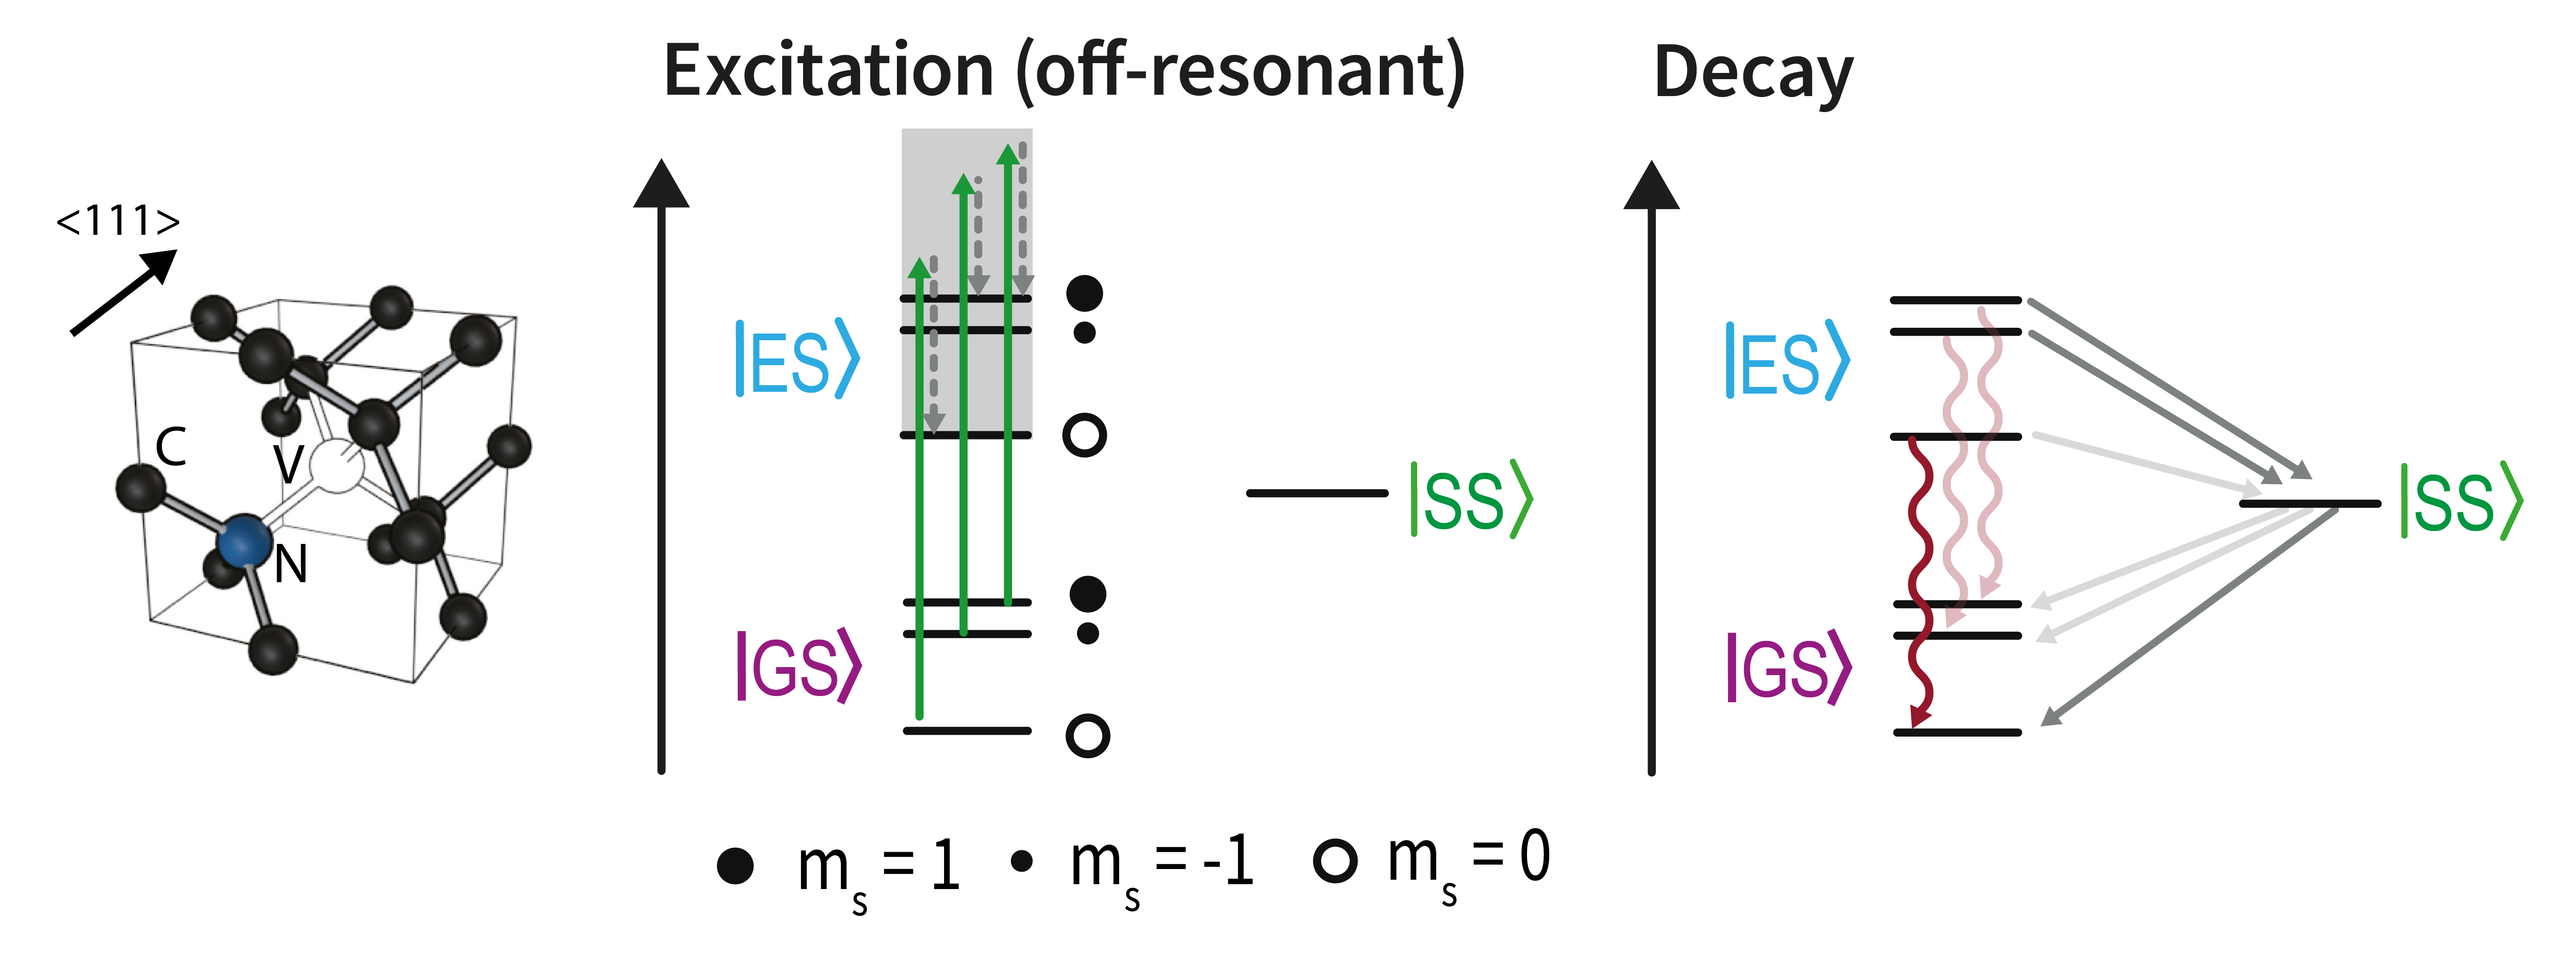

We will now simulate the spin-dependent fluorescence of an NV center during laser illumination using this model. We start by concstructing the Hilbert space of the NV center. We can either explicitly define the system ... 

In [ ]:
# NV center electron spin
S = {'val': 1, 'name':'S', 'type': 'NV-'} 

# Electronic states
GS = {'val': 0 , 'name':'GS'}
ES = {'val': 0 , 'name':'ES'}
SS = {'val': 0 , 'name':'SS'}

NV = sos.System(([(GS, ES), S], SS), method = "qutip")

... or make use of the NV submodule of the SimOS library. Here, we provide a class NVSystem() which allows to initialise the Hilbert space of NV centers for various approximations. Try out both options and you´ll see that we have constructed the exact same system. 

In [ ]:
NV = sos.NV.NVSystem(method = "qutip", nitrogen = False, orbital = False) # no coupled nitrogen, no electronic states

We continue to define the rates for the optical transions. Again, we can either explicitly do this by hand ... 

In [ ]:
# All rates are in 1/s
emission_rate = 55.7e6

NV_rates = {}

#  GS <-> ES transitions
NV_rates["ES,S[1]->GS,S[1]"]  = emission_rate
NV_rates["ES,S[-1]->GS,S[-1]"] = emission_rate
NV_rates["ES,S[0]->GS,S[0]"] = emission_rate

# Spin dependent rates for the ISC (Intersystem crossing) process
NV_rates["ES,S[1]->SS"] = 98.7e6
NV_rates["ES,S[-1]->SS"] = 98.7e6
NV_rates["ES,S[0]->SS"] = 8.2e6

# decay from shelving to ground state
NV_rates["SS->GS,S[0]"] = 4.8e6
NV_rates["SS->GS,S[1]"] = 2.2e6
NV_rates["SS->GS,S[-1]"] = 2.2e6

# tidyup the rate dictionary
NV_rates = sos.tidyup_ratedict(NV, NV_rates)

# Laser excitation
laser_rates = {"GS,S[0]->ES,S[0]": 0.2*emission_rate}
laser_rates["GS,S[1]->ES,S[1]"] = 0.2*emission_rate
laser_rates["GS,S[-1]->ES,S[-1]"] = 0.2*emission_rate

laser_rates = sos.tidyup_ratedict(NV, laser_rates)
allrates = sos.fuse_dictionaries(NV_rates,laser_rates)
c_ops_on = sos.transition_operators(NV, allrates)
c_ops_off = sos.transition_operators(NV, NV_rates)

... or by making use of the NV submodule. You can generate the collapse operators in the presence and absence of laser illumination with a one-line command. All you need to specify is the laser power (via a unit-less parameter beta = 0-1, 1 for saturation) and the temperature (not relevant for the classical simple model we are using here).


In [ ]:
c_ops_on, c_ops_off = NV.transition_operators(T = 300, beta = 0.2)

For the moment, we ignore any coherent interactions and solely consider these incoherent optical transitions. Since we are interested in the spin-dependence of the fluorescence (and the spin state initialisation), we will perform our simulation for three distinct initial spin states 
, a) a polarized state $m_s = 0$ in the electronic ground state (`rho0`) and b)  a polarized $m_s=-1$ state (`rho1`). The corresponding density matrices are indentical to the product of the projectors of the levels involved. 

Further, we define a measurement operator which we choose as the projector onto the excited state. (Note: The population of the excited state is proportional to the fluorescence.)

In [ ]:
# Inital states
rho0 = NV.GSid*NV.Sp[0]
rho1 = NV.GSid*NV.Sp[1]

# Observables
fluoresence = NV.ESid #*emission_rate

# Observable for the GS spin state polarization (S_z)
pol = NV.GSid*NV.Sz

Now we can evolve the system. We define our time axis for the propagation and run the simulation.

In [ ]:
tax = np.linspace(0,3e-6,101)
luminesence0 = []
luminesence1 = []

for t in tax:
    rho = rho0.copy()
    rho = sos.evol(0*NV.id, t, rho, c_ops = c_ops_on)
    meas = sos.expect(fluoresence , rho)
    luminesence0.append(meas)

    rho = rho1.copy()
    rho = sos.evol(0*NV.id, t, rho, c_ops = c_ops_on)
    meas = sos.expect(fluoresence , rho)
    luminesence1.append(meas)


Text(0, 0.5, 'Fluorescence [a.u.]')

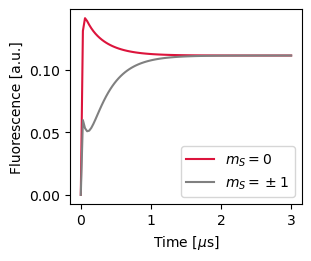

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (3,2.5), layout = "constrained")

ax.plot(tax/1e-6,luminesence0, label = r"$m_S=0$", color = "crimson")
ax.plot(tax/1e-6, luminesence1, label = r"$m_S=\pm1$", color = "grey")

ax.legend()
ax.set_xlabel(r"Time [$\mu$s]")
ax.set_ylabel(r"Fluorescence [a.u.]")
#plt.plot(luminesencetm)


In [ ]:
fig.savefig("NVsimple.pdf")

We can clearly observe (i) the spin dependent fluorescence of the NV center and (ii) the initialisation fo the spin state (polarization to $m_S = 0$ is achieved after approximately 1 $\mu$ s at this laser power).

Note that the code shown above for the time propagation is intuitive and easy to understand, yet inefficient. Since all interactions in our example are time-independent, we can run the time propagation more efficient by caching the propagator  superoperator for a single time step:

In [ ]:
dt = 10e-9 # time step 
Ubright = sos.evol(0*NV.id, dt, c_ops = c_ops_on) # propagator when laser is on 
Udark = sos.evol(0*NV.id, dt, c_ops = c_ops_off) # propagator when laser is off

Let's run the simulation again this way - you will see, it is much quicker!

In [ ]:
luminesence0 = []
luminesence1 = []
spin0 = []
spin1 = []
laser_state = []

pts = 400
rho0 = NV.GSid*NV.Sp[0]
rho1 = NV.GSid*NV.Sp[1]
for i in range(pts):
    meas = sos.expect(fluoresence , rho0)
    luminesence0.append(meas)
    meas = sos.expect(NV.Sp[0],rho0)
    spin0.append(meas)

    meas = sos.expect(fluoresence , rho1)
    luminesence1.append(meas)
    meas = sos.expect(NV.Sp[0],rho1)
    spin1.append(meas)


    if  i in range(50,250):
        rho0 = sos.applySuperoperator(Ubright,rho0)
        rho1 = sos.applySuperoperator(Ubright,rho1)
        laser_state.append(1)
    else:
        rho0 = sos.applySuperoperator(Udark,rho0)
        rho1 = sos.applySuperoperator(Udark,rho1)
        laser_state.append(0)

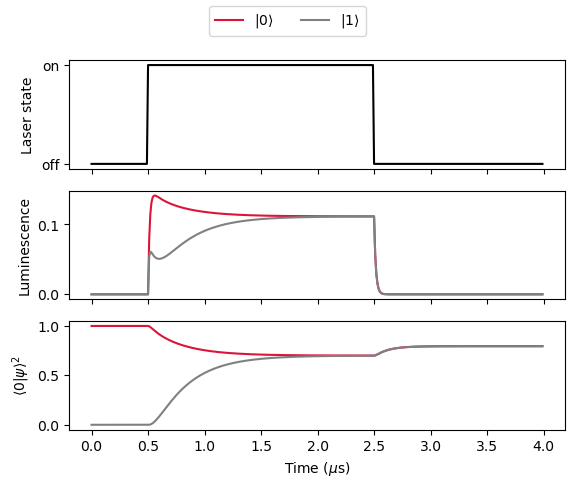

In [ ]:
tax = np.arange(pts)*dt*1e6 # in us

# make a 3 panel plot with a shared x axis

fig, axs = plt.subplots(3, sharex=True)

# Laser state in black top most panel
axs[0].plot(tax,laser_state, 'k')
axs[0].set_ylabel("Laser state")
# set ticks on y to text: 0: off and 1: on
axs[0].set_yticks([0,1])
axs[0].set_yticklabels(["off","on"])

# Luminescence in the middle panel
axs[1].plot(tax,luminesence0,label="$|0\\rangle$",color='crimson')
axs[1].plot(tax,luminesence1,label="$|1\\rangle$",color='grey')
axs[1].set_ylabel("Luminescence")

# Spin state in the bottom panel
axs[2].plot(tax,spin0,color='crimson')
axs[2].plot(tax,spin1,color='grey')
axs[2].set_ylabel("$\\langle 0 | \\psi \\rangle^2$")

plt.xlabel("Time ($\mu$s)")
# shared legend below the plot
fig.legend(loc='upper center', ncol=3)



Note that you can also use the ``simos.prop`` method to propagate the system. This method is a wrapper around parametrized time-dependent Hamiltonians and/or Liouvillians. It is the most efficient way to propagate the system.

# A full quantum mechanical model

We now continue to explore a comprehensive model of the spin dynamics of the negatively charged NV center, spanning the full temperature range from the low-to the high-temperature regime, including effects of applied magnetic and electric field bias.

For all details, see DOI: 10.1103/PhysRevB.108.085203.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import simos as sos
import scipy as sc

Again and in full analogy to the simple model above we start by setting up the NV center system and only consider the negatively charged state and neglect hyperfine couplings to surrounding nuclei.

However, we now take into account that the excited state (ES) of the NV center is an orbital doublet at cryogenic temperature. At room temperature rapid phonon-driven transitions result in an averaging to an effective orbital singlet. The interplay of spin and orbital dynamics in the ES results in fast spin relaxation and vanishing ODMR contrast at intermediate temperatures.  To capture these effects we have to explicitly introduce the ES as an orbital doublet. We do so by defining it with a value = 1/2 making it an effective two-level system. 

In [ ]:
# Spin NV , S=1:
S = {'val': 1, 'name':'S'} 
# Electronic Ground State NV- :
GS = {'val': 0 , 'name':'GS'}
# Electronic Excited State NV-, Orbital doublet:
ES = {'val': 0.5 , 'name':'ES'}
# Metastable Shelving State NV- :
SS = {'val': 0 , 'name':'SS'}

# Construct the system:
NV = sos.System(([(GS, ES), S], SS), method = "qutip")

Again, we could simply make use  of the NVsystem subroutine, and obtain this quantum system with a one-line-command:

In [ ]:
NV = sos.NV.NVSystem(method = "qutip", nitrogen = True, orbital = True)

In our full model, we will also take into account the coherent dynamics of the NV center. Therefore, we must define the strengths of both, incoherent and coherent interactions.   You can find detailed explanations for these interactions in the original reference (DOI: 10.1103/PhysRevB.108.085203.)
In the code below, we make use of the NV submodule functions to generate the coherent field Hamiltonian of the NV center and collapse operators for all incoherent transitions at three distinct temperatures. 

In [ ]:
# Define the Hamiltonian
E_perp = 40e9 # axial strain Hz 
phi_E = np.deg2rad(1.9) # degrees
Evec = sos.spher2cart(E_perp, np.deg2rad(90), np.deg2rad(phi_E)) # strain in cartesian coordinates 
B = 0e-3 # T 
theta_B = 0 # degrees
phi_B = 0 # degrees
Bvec = sos.spher2cart(B, theta_B, phi_B)# Bield in cartesian coordinates 
HGS, HES = NV.field_hamiltonian(Bvec = Bvec, EES_vec = sos.f2w(Evec))
H = HGS + HES
# all collapse operators
c_ops_on, c_ops_off = NV.transition_operators(T=300,  beta = 0.2, Bvec = Bvec, Evec = Evec)

In [ ]:
import copy
# Temperature-selection
temperatures = [0, 30, 300]

# Inital states
rho0 = NV.GSid*NV.Sp[0]
rho1 = NV.GSid*NV.Sp[1]
rhotm = NV.GSid.unit()
# Observables
fluoresence = NV.ESid #*emission_rate
# Observable for the GS spin state polarization (S_z)
pol = NV.GSid*NV.Sz
tax = np.linspace(0,1e-6,201)
dt = tax[1]-tax[0]

alll0 = []
alll1 = []
for temperature in temperatures:
    c_ops_on, c_ops_off = NV.transition_operators(T=temperature,  beta = 0.2, Bvec = Bvec, Evec = Evec)
    luminesence0 = []
    luminesence1 = []
    U  = sos.evol((HGS+HES), dt, c_ops = c_ops_on)
    rho_0 = rho0.copy()
    rho_1 = rho1.copy()
    for t in tax:
        luminesence0.append(sos.expect(fluoresence , rho_0))
        luminesence1.append(sos.expect(fluoresence , rho_1))  
        rho_0 = sos.applySuperoperator(U,rho_0)
        rho_1 = sos.applySuperoperator(U,rho_1)

    alll0.append(luminesence0)
    alll1.append(luminesence1)

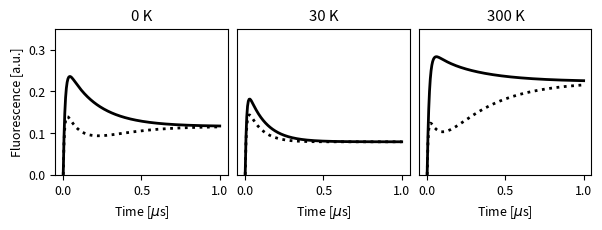

In [ ]:
colors = ["blue", "black", "red"]

def cm2inch(*value):
    value = list(value)
    for i in range(len(value)):
        value[i] = value[i]/2.54
    if len(value) == 1:
        return value[0]
    else:
        return value

plt.rcParams['svg.fonttype'] = 'none'
# Set font to Source Sans
plt.rcParams['font.family'] = 'Source Sans Pro'
# Set font size
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(1,3, figsize = cm2inch(15,9/sos.golden_ratio), layout = "constrained")
labels = ["0 K", "30 K", "300 K"]
colors = ["k", "k", "k"]
for ind_temperature, temperature in enumerate(temperatures):
    ax[ind_temperature].plot(tax/1e-6,alll0[ind_temperature], label =labels[ind_temperature], color = colors[ind_temperature], lw = 2)
    ax[ind_temperature].plot(tax/1e-6, alll1[ind_temperature], color = colors[ind_temperature], ls = "dotted", lw = 2)
    ax[ind_temperature].set_xlabel(r"Time [$\mu$s]")
    if ind_temperature == 0:
        ax[ind_temperature].set_ylabel(r"Fluorescence [a.u.]")
    else:
        ax[ind_temperature].yaxis.set_visible(False)

    ax[ind_temperature].set_ylim([0, 0.35])
    ax[ind_temperature].set_title(labels[ind_temperature])

We clearly observe reduced spin contrast in the intermediate temperature regime and a convergence to the classical, simple model at 300 K.

## An outlook for this notebook

This notebook showcases how to simulate photophysics of NV centers with SimOS. It provides a basis to explore the influence of individual parameters (laser strength, magnetic fields etc.) on spin contrast and preparation.  